In [1]:
import torch
torch.cuda.set_device(2)
if torch.cuda.is_available():
    current_gpu = torch.cuda.current_device()
    print(f"Current default GPU index: {current_gpu}")
    print(f"Current default GPU name: {torch.cuda.get_device_name(current_gpu)}")
else:
    print("No GPUs available.")

Current default GPU index: 2
Current default GPU name: NVIDIA A40


# imports

In [2]:
# all imports

# buffer
from collections import defaultdict
import random
from abc import ABC, abstractmethod
from typing import (
    Any,
    Dict,
    Generic,
    Optional,
    List,
    TYPE_CHECKING,
    Set,
    TypeVar,
)

from avalanche.benchmarks.utils import (
    classification_subset,
    AvalancheDataset,
)
from avalanche.models import FeatureExtractorBackbone
# from ..benchmarks.utils.utils import concat_datasets
from avalanche.benchmarks.utils import concat_datasets
from avalanche.training.storage_policy import ReservoirSamplingBuffer, BalancedExemplarsBuffer, ClassBalancedBuffer

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy, ExemplarsBuffer, ExperienceBalancedBuffer
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from avalanche.training.plugins import SupervisedPlugin
from typing import Optional, TYPE_CHECKING

from avalanche.benchmarks.utils import concat_classification_datasets
from avalanche.training.plugins.strategy_plugin import SupervisedPlugin

if TYPE_CHECKING:
    from avalanche.training.templates import SupervisedTemplate, BaseSGDTemplate

# dataset
from avalanche.benchmarks import SplitMNIST, SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10
from avalanche.benchmarks.utils.data_loader import GroupBalancedDataLoader, ReplayDataLoader
from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark
from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark

from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger, TensorboardLogger

from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics

from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1, ICaRL
from avalanche.models import SimpleMLP
from avalanche.training.plugins import ReplayPlugin
from types import SimpleNamespace
from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import inf

In [4]:
# all imports

import torch
import os
from torch import cat, Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset, ConcatDataset, TensorDataset
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchvision import datasets, transforms
import torch.optim.lr_scheduler # ?
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, CenterCrop, RandomHorizontalFlip, Resize
from torchvision.transforms.functional import center_crop
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.utils import save_image
from torchvision.transforms.functional import pil_to_tensor


In [5]:
# import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform = transform_train = Compose([
    # Resize(224),
    # Resize(384),
    # RandomHorizontalFlip(),
    ToTensor(),
    # Normalize(*stats,inplace=True)
])

# Load the CIFAR-100 training set
trainset = torchvision.datasets.CIFAR100(root='data', train=True,
                                         download=True, transform=transform)

name_list = trainset.classes

Files already downloaded and verified


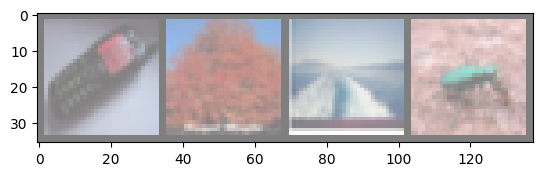

telephone maple_tree   sea beetle


In [6]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if Normalize was used in transform
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))


In [7]:

def tensor_to_pil(image_tensor):
    return transforms.ToPILImage()(image_tensor).convert("RGB")

In [8]:
import os
import torch
import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor
from torchvision.utils import save_image


def save_cifar100_random_replay(dataset, num_images_per_class, save_dir):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.manual_seed(41)

    saved_counts = {label: 0 for label in range(100)}  # Initialize saved image count for each class
    
    transform_to_tensor = transforms.ToTensor()
    
    indices = torch.randperm(len(dataset)).tolist()
    for idx in indices:
        image, label = dataset[idx]
        image_tensor = transform_to_tensor(image)

        # Skip saving if this class already has the desired number of images saved
        if saved_counts[label] >= num_images_per_class:
            continue

        class_name = dataset.classes[label]
        image_path = os.path.join(save_dir, f'{class_name}_{saved_counts[label]}.png')
        save_image(image_tensor, image_path)
        saved_counts[label] += 1

        # Check if we have finished saving max_images for all classes
        class_file_path = os.path.join(save_dir, f"class{label}.txt")
        with open(class_file_path, "a") as file:
            file.write(f"{image_path} {label}\n")

        # Check if we have finished saving the specified number of images for all classes
        if all(count >= num_images_per_class for count in saved_counts.values()):
            break

    print(f"Saved {num_images_per_class} images per class from the CIFAR-100 training dataset.")

In [9]:
# save_cifar100_random_replay(trainset, 50, 'saved_data/cifar0411_1')

In [10]:
integer_to_name = {i: name for i, name in enumerate(name_list)}


In [11]:
for id in integer_to_name:
    print(id, integer_to_name[id])
    break

0 apple


# Data transform

In [12]:
# !pip install pytorch_pretrained_vit


import torch
import matplotlib.pyplot as plt
import numpy as np
# ?

from avalanche.benchmarks.classic import SplitCIFAR100
from avalanche.benchmarks.classic import SplitCIFAR10

from avalanche.benchmarks.generators import nc_benchmark, ni_benchmark

from avalanche.benchmarks.generators import filelist_benchmark, dataset_benchmark, \
                                            tensors_benchmark, paths_benchmark



In [13]:
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, Resize
import os
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform_train = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(*stats,inplace=True)
])

transform_test = Compose([
    Resize((224,224)),
    ToTensor(),
    Normalize(*stats,inplace=True)
])


In [14]:
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.logging import InteractiveLogger, TensorboardLogger, \
    WandBLogger, TextLogger
# log to Tensorboard
tb_logger = TensorboardLogger()

# log to text file
text_logger = TextLogger(open('logs/test.txt', 'w'))

# print to stdout
interactive_logger = InteractiveLogger()

In [69]:
# evaluation
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, loss_metrics, class_accuracy_metrics

# The evaluation plugin manages the metrics computation.
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=False, epoch=True, experience=True, stream=True),
    class_accuracy_metrics(minibatch=False, epoch=False, epoch_running=False, experience=False, stream=True),
    # forgetting_metrics(experience=True, stream=True),
#     loggers=[interactive_logger, text_logger, tb_logger]
)

/homes/55/enbo/miniconda3/envs/thesis3.7/lib/python3.7/site-packages/avalanche/training/plugins/evaluation.py:68: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


In [70]:
from avalanche.training.plugins.checkpoint import CheckpointPlugin, \
    FileSystemCheckpointStorage
from avalanche.training.determinism.rng_manager import RNGManager


In [71]:
RNGManager.set_random_seeds(1234)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

checkpoint_plugin = CheckpointPlugin(
    FileSystemCheckpointStorage(
        directory='./checkpoints/task_cifar',
    ),
    map_location=device
)

# Load checkpoint (if exists in the given storage)
# If it does not exist, strategy will be None and initial_exp will be 0
strategy, initial_exp = checkpoint_plugin.load_checkpoint_if_exists()

cuda


In [72]:
import os
import random

def combine_files_with_numbers(folder, file_initial, numbers, output_folder):
    """use to get the data with label in the training experience"""
    combined_content = ""  # Initialize an empty string to store combined content
    # Compile a set of filenames to look for, based on the list of numbers
    filenames_to_look_for = {file_initial + f"{number}.txt" for number in numbers}

    # Iterate over each file in the specified folder
    for file in os.listdir(folder):
        # Check if the file name matches exactly any in our set of filenames to look for
        if file in filenames_to_look_for:
            # Open and read the file, then add its content to the combined_content string
            with open(os.path.join(folder, file), 'r') as f:
                combined_content += f.read()  # Add a newline character after each file's content for better separation

    joined_string = '_'.join(str(integer) for integer in numbers)

    os.makedirs(output_folder, exist_ok=True)

    output_file_path = output_folder +file_initial+ 'combined' + '_' + joined_string + '.txt'
    print(output_file_path)
    with open(output_file_path, 'w') as f:
        f.write(combined_content)

def shuffle_text_file_lines(file_path):
    """
    Shuffles the lines in a text file.

    Parameters:
    - file_path: Path to the text file to shuffle.
    """
    # Read the lines from the file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Shuffle the lines
    random.shuffle(lines)

    # Write the shuffled lines back to the file
    with open(file_path, 'w') as file:
        file.writelines(lines)

# customize replay plugin

In [73]:
class CustomReplay_SD(SupervisedPlugin):
    def __init__(
        self,
        # sd_data,
        mem_size: int = 200,
        batch_size: Optional[int] = None,
        batch_size_mem: Optional[int] = None,
        task_balanced_dataloader: bool = False,
        storage_policy: Optional["ExemplarsBuffer"] = None,
        image_folder = None
        # The policy that controls how to add new exemplars in memory
                        #
    ):
        super().__init__()
        # self.sd_data = sd_data
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.batch_size_mem = batch_size_mem
        self.task_balanced_dataloader = task_balanced_dataloader

        self.storage_policy = storage_policy
        self.image_folder = image_folder
        assert storage_policy.max_size == self.mem_size

        if storage_policy is not None:  # Use other storage policy
            self.storage_policy = storage_policy
            assert storage_policy.max_size == self.mem_size
        else:  # Default
            self.storage_policy = ExperienceBalancedBuffer(
                max_size=self.mem_size, adaptive_size=True
            )

    def before_training_exp(
        self,
        strategy: "SupervisedTemplate",
        num_workers: int = 0,
        shuffle: bool = True,
        drop_last: bool = False,
        **kwargs
    ):
        """
        Dataloader to build batches containing examples from both memories and
        the training dataset
        """
        if len(self.storage_policy.buffer) == 0:
            return

#         batch_size = self.batch_size
#         if batch_size is None:
#             batch_size = strategy.train_mb_size

        batch_size_mem = self.batch_size_mem
        if batch_size_mem is None:
            batch_size_mem = strategy.train_mb_size

        assert strategy.adapted_dataset is not None
        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            batch_size=strategy.train_mb_size,
            num_workers=num_workers,
            shuffle=shuffle,
        )

    def after_training_exp(self, strategy: "SupervisedTemplate", **kwargs):
        """ We update the buffer after the experience.
            You can use a different callback to update the buffer in a different place
        """
        print("Buffer update.")
        buffer_size = len(self.storage_policy.buffer)
        print("buffer size: " + str(buffer_size))
        num_class = len(self.storage_policy.buffer_datasets)
        print("current class number in replay buffer: " + str(num_class))
        # self.storage_policy.update(strategy, **kwargs)

        # print(type(strategy.experience))

        current_experience = strategy.experience

        current_classes = current_experience.classes_in_this_experience
        print(current_classes)
        # create the combined txt file with current classes
        print("start to combine files...")
        combine_files_with_numbers(
            self.image_folder,
            'class',
            current_classes,
            self.image_folder + 'combined/')
        joined_string = '_'.join(str(integer) for integer in current_classes)
        combined_file_name = self.image_folder + 'combined/' + 'class' + 'combined' + '_' + joined_string + '.txt'

        cur_train_set = [combined_file_name]

        print("start generating sd data scenario...")
        sd_dataset_scenario =  filelist_benchmark(
                                None,
                                train_file_lists = cur_train_set, # train
                                test_file_lists = [], # test
                                task_labels = [0],
                                # complete_test_set_only=True,
                                train_transform=transform_train,
                            eval_transform=transform_train
                            )
        sd_data = SimpleNamespace(experience = sd_dataset_scenario.train_stream[0])
        # storage_p.update(strategy_state)

        print("start updating sd data into buffer")
        self.storage_policy.update(sd_data, **kwargs)


# experiment 20 tasks

In [74]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss

In [75]:
import torch
import torch.nn as nn
# resnet50 = torch.hub.load('ckpt/dino_resnet50_pretrain.pth', 'dino_resnet50')
resnet_model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
resnet_model.fc = nn.Identity()

for param in resnet_model.parameters():
    param.requires_grad = False
    

# # Step 2: Create a new network class with an additional linear layer
# class CustomNetwork(nn.Module):
#     def __init__(self, pretrained_model, num_classes):
#         super(CustomNetwork, self).__init__()
#         self.pretrained_model = pretrained_model
#         self.fc = nn.Linear(2048, num_classes)  # New linear layer with trainable weights

#     def forward(self, x):
#         # Extract features using the pre-trained model
#         features = self.pretrained_model(x)
#         # Flatten the output for the linear layer if not already flattened
#         features = torch.flatten(features, 1)
#         # Pass features through the new linear layer
#         output = self.fc(features)
#         return output

# # Step 3: Initialize the new network with the desired number of output classes
# num_classes = 100  # Example: 10 classes for a new classification task
# resnet_model = CustomNetwork(resnet_model, num_classes)

# # The only parameters that are trainable are those of the new linear layer


Using cache found in /homes/55/enbo/.cache/torch/hub/facebookresearch_dino_main


In [76]:
import torch.nn as nn
import torch
from avalanche.training.templates import SupervisedTemplate
from avalanche.benchmarks.utils import AvalancheDataset
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

import torch
from avalanche.training.plugins import SupervisedPlugin
from avalanche.benchmarks.utils.data_loader import ReplayDataLoader
from typing import Optional

class DINOFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load the pre-trained DINO model
        self.feature_extractor = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        # Remove the head or adapt it to return features instead of logits
        self.feature_extractor.fc = nn.Identity()
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Extract features using the DINO backbone
        return self.feature_extractor(x)

In [77]:
# training
from avalanche.training import Naive, CWRStar, Replay, GDumb, \
    Cumulative, LwF, GEM, AGEM, EWC, AR1

# strategies
from avalanche.models import SimpleMLP
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.plugins import ReplayPlugin

from types import SimpleNamespace

In [78]:
benchmark = SplitCIFAR100(n_experiences=20,
                          train_transform=transform_train,
                          eval_transform = transform_test,
                          seed = 41
                          )

Files already downloaded and verified
Files already downloaded and verified


In [401]:
from abc import ABC
from typing import TypeVar, Generic
from typing import TYPE_CHECKING

if TYPE_CHECKING:
    from avalanche.training.templates.base import BaseTemplate

CallbackResult = TypeVar("CallbackResult")
Template = TypeVar("Template", bound="BaseTemplate")


class BasePlugin(Generic[Template], ABC):
    """ABC for BaseTemplate plugins.

    A plugin is simply an object implementing some strategy callbacks.
    Plugins are called automatically during the strategy execution.

    Callbacks provide access before/after each phase of the execution.
    In general, for each method of the training and evaluation loops,
    `StrategyCallbacks`
    provide two functions `before_{method}` and `after_{method}`, called
    before and after the method, respectively.
    Therefore plugins can "inject" additional code by implementing callbacks.
    Each callback has a `strategy` argument that gives access to the state.

    In Avalanche, callbacks are used to implement continual strategies, metrics
    and loggers.
    """

    def __init__(self):
        pass


    def before_training(self, strategy: Template, *args, **kwargs):
        """Called before `train` by the `BaseTemplate`."""
        pass

    def before_training_exp(self, strategy: Template, *args, **kwargs):
        """Called before `train_exp` by the `BaseTemplate`."""
        pass

    def after_training_exp(self, strategy: Template, *args, **kwargs):
        """Called after `train_exp` by the `BaseTemplate`."""
        pass

    def after_training(self, strategy: Template, *args, **kwargs):
        """Called after `train` by the `BaseTemplate`."""
        pass

    def before_eval(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `eval` by the `BaseTemplate`."""
        pass

    def before_eval_exp(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `eval_exp` by the `BaseTemplate`."""
        pass

    def after_eval_exp(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `eval_exp` by the `BaseTemplate`."""
        pass

    def after_eval(self, strategy: Template, *args, **kwargs) -> CallbackResult:
        """Called after `eval` by the `BaseTemplate`."""
        pass

class Knn_DinoPlugin(BasePlugin[Template], ABC):
    """ABC for BaseSGDTemplate plugins.

    See `BaseSGDTemplate` for complete description of the train/eval loop.
    """

    def before_training_epoch(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `train_epoch` by the `BaseTemplate`."""
        pass

    def before_training_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before the start of a training iteration by the
        `BaseTemplate`."""
        pass

    def before_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `model.forward()` by the `BaseTemplate`."""
        pass

    def after_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `model.forward()` by the `BaseTemplate`."""
        pass

    def before_backward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `criterion.backward()` by the `BaseTemplate`."""
        pass

    def after_backward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `criterion.backward()` by the `BaseTemplate`."""
        pass

    def after_training_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after the end of a training iteration by the
        `BaseTemplate`."""
        print('plugin')
        
        pass

    def before_update(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `optimizer.update()` by the `BaseTemplate`."""
        pass

    def after_update(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `optimizer.update()` by the `BaseTemplate`."""
        pass

    def after_training_epoch(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `train_epoch` by the `BaseTemplate`."""
        pass

    def before_eval_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before the start of a training iteration by the
        `BaseTemplate`."""
        pass

    def before_eval_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called before `model.forward()` by the `BaseTemplate`."""
        pass

    def after_eval_forward(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after `model.forward()` by the `BaseTemplate`."""
        pass

    def after_eval_iteration(
        self, strategy: Template, *args, **kwargs
    ) -> CallbackResult:
        """Called after the end of an iteration by the
        `BaseTemplate`."""
        pass

In [476]:
# from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
# from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
# storage_p = ParametricBuffer(
#     max_size=60000,
#     groupby='class',
#     selection_strategy=RandomExemplarsSelectionStrategy()
#     # selection_strategy=RandomExemplarsSelectionStrategy()

# )


# print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
# for i in range(5):
#     strategy_state = SimpleNamespace(experience=benchmark.train_stream[i])
#     # print(len(benchmark.train_stream[i]))
#     storage_p.update(strategy_state)
#     print(f"Max buffer size: {storage_p.max_size}, current size: {len(storage_p.buffer)}")
#     # print(f"class targets: {storage_p.buffer.targets}\n")

# storage_p = ParametricBuffer(
#     max_size=60000,
#     groupby='class',
#     selection_strategy=RandomExemplarsSelectionStrategy()
#     # selection_strategy=RandomExemplarsSelectionStrategy()

# )

In [477]:
from typing import Iterable, Sequence, Optional, Union, List
from pkg_resources import parse_version

import torch
from torch.nn import Module, CrossEntropyLoss
from torch.optim import Optimizer
from torch.utils.data import DataLoader

from avalanche.benchmarks import CLExperience, CLStream
from avalanche.core import BaseSGDPlugin
from avalanche.training.plugins import SupervisedPlugin, EvaluationPlugin
from avalanche.training.plugins.clock import Clock
from avalanche.training.plugins.evaluation import default_evaluator
from avalanche.training.templates.base import BaseTemplate, ExpSequence
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.benchmarks.utils.data_loader import TaskBalancedDataLoader, \
    collate_from_data_or_kwargs
from avalanche.training.utils import trigger_plugins

In [478]:
# class KNN_DINO1(BaseTemplate):
#     """Base SGD class for continual learning skeletons.

#     **Training loop**
#     The training loop is organized as follows::

#         train
#             train_exp  # for each experience

#     **Evaluation loop**
#     The evaluation loop is organized as follows::

#         eval
#             eval_exp  # for each experience

#     """

#     PLUGIN_CLASS = BaseSGDPlugin

#     def __init__(
#         self,
#         model: Module,
# #         optimizer: Optimizer,
# #         criterion=CrossEntropyLoss(),
#         train_mb_size: int = 1,
#         train_epochs: int = 1,
#         eval_mb_size: Optional[int] = 1,
#         device="cpu",
#         plugins: Optional[List["SupervisedPlugin"]] = None,
#         evaluator: EvaluationPlugin = default_evaluator(),
#         eval_every=-1,
#         peval_mode="epoch",
#         k: int = 5,
#         T: float = 0.07
#     ):
#         """Init.

#         :param model: PyTorch model.
#         :param optimizer: PyTorch optimizer.
#         :param criterion: loss function.
#         :param train_mb_size: mini-batch size for training.
#         :param train_epochs: number of training epochs.
#         :param eval_mb_size: mini-batch size for eval.
#         :param evaluator: (optional) instance of EvaluationPlugin for logging
#             and metric computations. None to remove logging.
#         :param eval_every: the frequency of the calls to `eval` inside the
#             training loop. -1 disables the evaluation. 0 means `eval` is called
#             only at the end of the learning experience. Values >0 mean that
#             `eval` is called every `eval_every` epochs and at the end of the
#             learning experience.
#         :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
#             periodic evaluation during training should execute every
#             `eval_every` epochs or iterations (Default='epoch').
#         """
#         super().__init__(model=model, device=device, plugins=plugins)

# #         self.optimizer: Optimizer = optimizer
# #         """ PyTorch optimizer. """

# #         self._criterion = criterion
# #         """ Criterion. """

#         self.train_epochs: int = train_epochs
#         """ Number of training epochs. """

#         self.train_mb_size: int = train_mb_size
#         """ Training mini-batch size. """

#         self.eval_mb_size: int = (
#             train_mb_size if eval_mb_size is None else eval_mb_size
#         )
#         """ Eval mini-batch size. """

#         if evaluator is None:
#             evaluator = EvaluationPlugin()
#         self.plugins.append(evaluator)
#         self.evaluator = evaluator
#         """ EvaluationPlugin used for logging and metric computations. """

#         # Configure periodic evaluation.
#         assert peval_mode in {"experience", "epoch", "iteration"}
#         self.eval_every = eval_every
# #         peval = PeriodicEval(eval_every, peval_mode)
# #         self.plugins.append(peval)

#         self.clock = Clock()
#         """ Incremental counters for strategy events. """
#         # WARNING: Clock needs to be the last plugin, otherwise
#         # counters will be wrong for plugins called after it.
#         self.plugins.append(self.clock)

#         ###################################################################
#         # State variables. These are updated during the train/eval loops. #
#         ###################################################################

#         self.adapted_dataset = None
#         """ Data used to train. It may be modified by plugins. Plugins can 
#         append data to it (e.g. for replay). 

#         .. note::

#             This dataset may contain samples from different experiences. If you 
#             want the original data for the current experience  
#             use :attr:`.BaseTemplate.experience`.
#         """

#         self.dataloader = None
#         self.mbatch = None
#         self.mb_output = None
#         self.loss = None
#         self._stop_training = False
#         self.k = k
#         self.T = T
#         self.train_features = None
#         self.train_labels = None

#     @torch.no_grad()
#     def train(self,
#               experiences: Union[CLExperience,
#                                  ExpSequence],
#               eval_streams: Optional[Sequence[Union[CLExperience,
#                                                     ExpSequence]]] = None,
#               **kwargs):

# #         super().train(experiences, eval_streams, **kwargs)
# #         return self.evaluator.get_last_metrics()
#         self.model.eval()  # Feature extraction mode, so we set the model to eval
#         with torch.no_grad():
#             if not isinstance(experiences, Iterable):
#                 experiences = [experiences]
#             for experience in experiences:
#                 self._before_training_exp(**kwargs)
#                 self._train_exp(experience, **kwargs)
    
        

#     @torch.no_grad()
#     def eval(self, exp_list: Union[CLExperience, CLStream], **kwargs):
#         """
#         Evaluate the current model on a series of experiences and
#         returns the last recorded value for each metric.

#         :param exp_list: CL experience information.
#         :param kwargs: custom arguments.

#         :return: dictionary containing last recorded value for
#             each metric name
#         """
#         super().eval(exp_list, **kwargs)
#         return self.evaluator.get_last_metrics()

# #     def _train_exp(
# #         self, experience: CLExperience, eval_streams, **kwargs
# #     ):
# #         # Should be implemented in Observation Type
# #         raise NotImplementedError()

#     def _eval_exp(self, **kwargs):
#         self.eval_epoch(**kwargs)

#     def make_optimizer(self, **kwargs):
#         """Optimizer initialization."""
#         # Should be implemented in Observation Type
#         pass

#     def criterion(self):
#         """Compute loss function."""
#         pass

#     def forward(self):
#         """Compute the model's output given the current mini-batch."""
# #         raise NotImplementedError()
#         return self.model(x)

#     def model_adaptation(self, model=None):
#         """Adapts the model to the current experience."""
#         pass

#     def stop_training(self):
#         """Signals to stop training at the next iteration."""
#         self._stop_training = True

#     def training_epoch(self, **kwargs):
#         # Should be implemented in Update Type
# #         raise NotADirectoryError()
        
#         print('training_epoch', self.dataloader)
#         for self.mbatch in self.dataloader:
#             self._unpack_minibatch()
#             self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             pass
#             self._after_training_iteration(**kwargs)

#     def backward(self):
#         """Run the backward pass."""
#         pass

#     def optimizer_step(self):
#         """Execute the optimizer step (weights update)."""
#         pass

#     def eval_epoch(self, **kwargs):
#         """Evaluation loop over the current `self.dataloader`."""
#         for self.mbatch in self.dataloader:
#             inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
#             self._unpack_minibatch()
#             self._before_eval_iteration(**kwargs)

#             self._before_eval_forward(**kwargs)
#             features = self.model(inputs) 
# #             self.mb_output = self.forward()
#             predictions = self.knn_classifier(features, self.train_features, self.train_labels, k=self.k, T=self.T)
#             self.mb_output = predictions  # Set the minibatch output to KNN predictions

#             self._after_eval_forward(**kwargs)
# #             self.loss = self.criterion()

#             self._after_eval_iteration(**kwargs)
    
#     def knn_classifier(self, test_features, train_labels):
#     # Assuming train_features are transposed and ready to be used for dot product similarity
#         distances, indices = torch.cdist(test_features, self.train_features).topk(self.k, largest=False, sorted=True)
#         retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

#         # Voting or averaging can happen here depending on your approach, example with voting:
#         predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         print('prediction is', predictions)
#         return predictions

#     def check_model_and_optimizer(self):
#         # Should be implemented in observation type
#         pass

#     def _before_training_exp(self, **kwargs):
#         """Setup to train on a single experience."""
#         # Data Adaptation (e.g. add new samples/data augmentation)
#         print('Data Adaptation')
#         self._before_train_dataset_adaptation(**kwargs)
#         self.train_dataset_adaptation(**kwargs)
#         self._after_train_dataset_adaptation(**kwargs)
#         print('make_train_dataloader')
#         self.make_train_dataloader(**kwargs)
#         print('_before_training_exp', self.dataloader)

#         # Model Adaptation (e.g. freeze/add new units)
#         print('Model Adaptation')
#         self.model = self.model_adaptation()
#         # self.make_optimizer()
#         print('check_model_and_optimizer')
#         self.check_model_and_optimizer()

#         super()._before_training_exp(**kwargs)
    
        
#     def _train_exp(
#         self, experience: CLExperience, eval_streams=None, **kwargs
#     ):
#         """Training loop over a single Experience object.

#         :param experience: CL experience information.
#         :param eval_streams: list of streams for evaluation.
#             If None: use the training experience for evaluation.
#             Use [] if you do not want to evaluate during training.
#         :param kwargs: custom arguments.
#         """
#         if eval_streams is None:
#             eval_streams = [experience]
#         self.model.eval()  # Ensure the model is in evaluation mode
# #         self.make_train_dataloader()
#         with torch.no_grad():
#             for i, exp in enumerate(eval_streams):
#                 if not isinstance(exp, Iterable):
#                     eval_streams[i] = [exp]
#             for _ in range(self.train_epochs):
#                 self._before_training_epoch(**kwargs)
# #                 print(self.dataloader)

#                 if self._stop_training:  # Early stopping
#                     self._stop_training = False
#                     break

#                 self.training_epoch(**kwargs)
#                 self._after_training_epoch(**kwargs)

#     def _save_train_state(self):
#         """Save the training state which may be modified by the eval loop.

#         This currently includes: experience, adapted_dataset, dataloader,
#         is_training, and train/eval modes for each module.

#         TODO: we probably need a better way to do this.
#         """
#         state = super()._save_train_state()
#         new_state = {
#             "adapted_dataset": self.adapted_dataset,
#             "dataloader": self.dataloader,
#         }
#         return {**state, **new_state}
    
#     def _before_train_dataset_adaptation(self, **kwargs):
#         pass
#     def train_dataset_adaptation(self, **kwargs):
#         """Initialize `self.adapted_dataset`."""
#         self.adapted_dataset = self.experience.dataset
#         self.adapted_dataset = self.adapted_dataset.train()

#     def _load_train_state(self, prev_state):
#         super()._load_train_state(prev_state)
#         self.adapted_dataset = prev_state["adapted_dataset"]
#         self.dataloader = prev_state["dataloader"]

#     def _before_eval_exp(self, **kwargs):

#         # Data Adaptation
#         self._before_eval_dataset_adaptation(**kwargs)
#         self.eval_dataset_adaptation(**kwargs)
#         self._after_eval_dataset_adaptation(**kwargs)

#         self.make_eval_dataloader(**kwargs)
#         # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()

#         super()._before_eval_exp(**kwargs)

#     def make_train_dataloader(
#         self,
#         num_workers=0,
#         shuffle=True,
#         pin_memory=True,
#         persistent_workers=False,
#         **kwargs
#     ):
#         """Data loader initialization.

#         Called at the start of each learning experience after the dataset
#         adaptation.

#         :param num_workers: number of thread workers for the data loading.
#         :param shuffle: True if the data should be shuffled, False otherwise.
#         :param pin_memory: If True, the data loader will copy Tensors into CUDA
#             pinned memory before returning them. Defaults to True.
#         """

#         other_dataloader_args = {}

#         if parse_version(torch.__version__) >= parse_version("1.7.0"):
#             other_dataloader_args["persistent_workers"] = persistent_workers
#         for k, v in kwargs.items():
#             other_dataloader_args[k] = v

#         self.dataloader = TaskBalancedDataLoader(
#             self.adapted_dataset,
#             oversample_small_groups=True,
#             num_workers=num_workers,
#             batch_size=self.train_mb_size,
#             shuffle=shuffle,
#             pin_memory=pin_memory,
#             **other_dataloader_args
#         )

#     def make_eval_dataloader(
#         self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
#     ):
#         """
#         Initializes the eval data loader.
#         :param num_workers: How many subprocesses to use for data loading.
#             0 means that the data will be loaded in the main process.
#             (default: 0).
#         :param pin_memory: If True, the data loader will copy Tensors into CUDA
#             pinned memory before returning them. Defaults to True.
#         :param kwargs:
#         :return:
#         """
#         other_dataloader_args = {}

#         if parse_version(torch.__version__) >= parse_version("1.7.0"):
#             other_dataloader_args["persistent_workers"] = persistent_workers
#         for k, v in kwargs.items():
#             other_dataloader_args[k] = v

#         collate_from_data_or_kwargs(self.adapted_dataset,
#                                     other_dataloader_args)
#         self.dataloader = DataLoader(
#             self.adapted_dataset,
#             num_workers=num_workers,
#             batch_size=self.eval_mb_size,
#             pin_memory=pin_memory,
#             **other_dataloader_args
#         )

#     def eval_dataset_adaptation(self, **kwargs):
#         """Initialize `self.adapted_dataset`."""
#         self.adapted_dataset = self.experience.dataset
#         self.adapted_dataset = self.adapted_dataset.eval()

#     def _unpack_minibatch(self):
#         """Move to device"""
#         # First verify the mini-batch
#         self._check_minibatch()

#         if isinstance(self.mbatch, tuple):
#             self.mbatch = list(self.mbatch)
#         for i in range(len(self.mbatch)):
#             self.mbatch[i] = self.mbatch[i].to(self.device)

#     #########################################################
#     # Plugin Triggers                                       #
#     #########################################################

#     def _before_training_epoch(self, **kwargs):
#         trigger_plugins(self, "before_training_epoch", **kwargs)

#     def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)

#     def _before_training_iteration(self, **kwargs):
#         trigger_plugins(self, "before_training_iteration", **kwargs)

#     def _before_forward(self, **kwargs):
#         trigger_plugins(self, "before_forward", **kwargs)

#     def _after_forward(self, **kwargs):
#         trigger_plugins(self, "after_forward", **kwargs)

#     def _before_backward(self, **kwargs):
#         trigger_plugins(self, "before_backward", **kwargs)

#     def _after_backward(self, **kwargs):
#         trigger_plugins(self, "after_backward", **kwargs)

#     def _after_training_iteration(self, **kwargs):
#         trigger_plugins(self, "after_training_iteration", **kwargs)

#     def _before_update(self, **kwargs):
#         trigger_plugins(self, "before_update", **kwargs)

#     def _after_update(self, **kwargs):
#         trigger_plugins(self, "after_update", **kwargs)

#     def _before_eval_iteration(self, **kwargs):
#         trigger_plugins(self, "before_eval_iteration", **kwargs)

#     def _before_eval_forward(self, **kwargs):
#         trigger_plugins(self, "before_eval_forward", **kwargs)

#     def _after_eval_forward(self, **kwargs):
#         trigger_plugins(self, "after_eval_forward", **kwargs)

#     def _after_eval_iteration(self, **kwargs):
#         trigger_plugins(self, "after_eval_iteration", **kwargs)

#     # ==================================================================> NEW

#     def _before_train_dataset_adaptation(self, **kwargs):
#         trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

#     def _after_train_dataset_adaptation(self, **kwargs):
#         trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

#     def _before_eval_dataset_adaptation(self, **kwargs):
#         trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

#     def _after_eval_dataset_adaptation(self, **kwargs):
#         trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
# # 

# KNN_storagePlugin

In [904]:
from torchmetrics import Accuracy  # Using torchmetrics for simplicity
# from avalanche.evaluation.metrics import Accuracy

from torchmetrics import Accuracy

class AccuracyMetric:
    def __init__(self, task='multiclass'):
        # Initialize the metric for multiclass classification by default
        self.metric = Accuracy(num_classes=None, average='macro', task=task)

    def update(self, preds, targets):
        preds, targets = preds.detach(), targets.detach()
        self.metric.update(preds, targets)

    def result(self):
        return self.metric.compute()

    def reset(self):
        self.metric.reset()


In [908]:

class KNN_storagePlugin(SupervisedPlugin):
    """
    Experience replay plugin.

    Handles an external memory filled with randomly selected
    patterns and implementing `before_training_exp` and `after_training_exp`
    callbacks.
    The `before_training_exp` callback is implemented in order to use the
    dataloader that creates mini-batches with examples from both training
    data and external memory. The examples in the mini-batch is balanced
    such that there are the same number of examples for each experience.

    The `after_training_exp` callback is implemented in order to add new
    patterns to the external memory.

    The :mem_size: attribute controls the total number of patterns to be stored
    in the external memory.

    :param batch_size: the size of the data batch. If set to `None`, it
        will be set equal to the strategy's batch size.
    :param batch_size_mem: the size of the memory batch. If
        `task_balanced_dataloader` is set to True, it must be greater than or
        equal to the number of tasks. If its value is set to `None`
        (the default value), it will be automatically set equal to the
        data batch size.
    :param task_balanced_dataloader: if True, buffer data loaders will be
            task-balanced, otherwise it will create a single dataloader for the
            buffer samples.
    :param storage_policy: The policy that controls how to add new exemplars
                           in memory
    """

    def __init__(
        self,
        mem_size: int = 200,
        batch_size: int = None,
        batch_size_mem: int = None,
        task_balanced_dataloader: bool = False,
        storage_policy: Optional["ExemplarsBuffer"] = None,
    ):
        super().__init__()
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.batch_size_mem = batch_size_mem
        self.task_balanced_dataloader = task_balanced_dataloader

        if storage_policy is not None:  # Use other storage policy
            self.storage_policy = storage_policy
            assert storage_policy.max_size == self.mem_size
        else:  # Default
            self.storage_policy = ExperienceBalancedBuffer(
                max_size=self.mem_size, adaptive_size=True
            )
        self.accuracy_metric = AccuracyMetric(task='multiclass')

    @property
    def ext_mem(self):
        return self.storage_policy.buffer_groups  # a Dict<task_id, Dataset>

    def before_training_exp(
        self,
        strategy: "SupervisedTemplate",
        num_workers: int = 0,
        shuffle: bool = True,
        **kwargs
    ):
        """
        Dataloader to build batches containing examples from both memories and
        the training dataset
        """
        if len(self.storage_policy.buffer) == 0:
            # first experience. We don't use the buffer, no need to change
            # the dataloader.
            buffer_size = len(self.storage_policy.buffer)
            print("buffer size: " + str(buffer_size))
            return

        batch_size = self.batch_size
        if batch_size is None:
            batch_size = strategy.train_mb_size

        batch_size_mem = self.batch_size_mem
        if batch_size_mem is None:
            batch_size_mem = strategy.train_mb_size

        strategy.dataloader = ReplayDataLoader(
            strategy.adapted_dataset,
            self.storage_policy.buffer,
            oversample_small_tasks=True,
            batch_size=batch_size,
            batch_size_mem=batch_size_mem,
            task_balanced_dataloader=self.task_balanced_dataloader,
            num_workers=num_workers,
            shuffle=shuffle,
        )
        buffer_size = len(self.storage_policy.buffer)
        print("buffer size: " + str(buffer_size))

    def after_training_exp(self, strategy: "SupervisedTemplate", **kwargs):
        self.storage_policy.update(strategy, **kwargs)
        buffer_size = len(self.storage_policy.buffer)
        print("after training exp buffer size: " + str(buffer_size))
    def after_eval_iteration(self, strategy: "SupervisedTemplate", **kwargs):
        """
        Calculate and log the accuracy after each evaluation iteration.
        """
        # Access the predictions and true labels
        predictions = strategy.mb_output
        true_labels = strategy.mb_y

        # Update the accuracy metric
        self.accuracy_metric.update(predictions, true_labels)

        # Log the current accuracy
        current_accuracy = self.accuracy_metric.result()
        print(f"Current accuracy: {current_accuracy * 100:.2f}%")
        self.accuracy_metric.reset()  # Reset for next iteration or experience



# KNN_DINO

In [909]:


class KNN_DINO1(BaseTemplate):
    """Base SGD class for continual learning skeletons.

    **Training loop**
    The training loop is organized as follows::

        train
            train_exp  # for each experience

    **Evaluation loop**
    The evaluation loop is organized as follows::

        eval
            eval_exp  # for each experience

    """

    PLUGIN_CLASS = BaseSGDPlugin

    def __init__(
        self,
        model: Module,
#         optimizer: Optimizer,
#         criterion=CrossEntropyLoss(),
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device="cpu",
        plugins: Optional[List["SupervisedPlugin"]] = None,
        evaluator: EvaluationPlugin = default_evaluator(),
        eval_every=-1,
        peval_mode="epoch",
        k: int = 5,
        T: float = 0.07
    ):
        """Init.

        :param model: PyTorch model.
        :param optimizer: PyTorch optimizer.
        :param criterion: loss function.
        :param train_mb_size: mini-batch size for training.
        :param train_epochs: number of training epochs.
        :param eval_mb_size: mini-batch size for eval.
        :param evaluator: (optional) instance of EvaluationPlugin for logging
            and metric computations. None to remove logging.
        :param eval_every: the frequency of the calls to `eval` inside the
            training loop. -1 disables the evaluation. 0 means `eval` is called
            only at the end of the learning experience. Values >0 mean that
            `eval` is called every `eval_every` epochs and at the end of the
            learning experience.
        :param peval_mode: one of {'epoch', 'iteration'}. Decides whether the
            periodic evaluation during training should execute every
            `eval_every` epochs or iterations (Default='epoch').
        """
        super().__init__(model=model, device=device, plugins=plugins)

#         self.optimizer: Optimizer = optimizer
#         """ PyTorch optimizer. """

#         self._criterion = criterion
#         """ Criterion. """

        self.train_epochs: int = train_epochs
        """ Number of training epochs. """

        self.train_mb_size: int = train_mb_size
        """ Training mini-batch size. """

        self.eval_mb_size: int = (
            train_mb_size if eval_mb_size is None else eval_mb_size
        )
        """ Eval mini-batch size. """

        if evaluator is None:
            evaluator = EvaluationPlugin()
        self.plugins.append(evaluator)
        self.evaluator = evaluator
        assert peval_mode in {"experience", "epoch", "iteration"}
        self.eval_every = eval_every
#         peval = PeriodicEval(eval_every, peval_mode)
#         self.plugins.append(peval)

        self.clock = Clock()
        """ Incremental counters for strategy events. """
        self.plugins.append(self.clock)

        self.adapted_dataset = None
        """ Data used to train. It may be modified by plugins. Plugins can 
        append data to it (e.g. for replay). 

        .. note::

            This dataset may contain samples from different experiences. If you 
            want the original data for the current experience  
            use :attr:`.BaseTemplate.experience`.
        """
        self.model = model
        self.dataloader = None
        self.mbatch = None
        self.mb_output = None
        self.loss = None
        self._stop_training = False
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None
        self.replay_plugin = plugins[0]

    @torch.no_grad()
    def train(self,
              experiences: Union[CLExperience,
                                 ExpSequence],
              eval_streams: Optional[Sequence[Union[CLExperience,
                                                    ExpSequence]]] = None,
              **kwargs):

#         super().train(experiences, eval_streams, **kwargs)
#         return self.evaluator.get_last_metrics()
        self.is_training = True
        self._stop_training = False

        self.model.eval()  # Feature extraction mode, so we set the model to eval
        self.model.to(self.device)
        with torch.no_grad():
            if not isinstance(experiences, Iterable):
                experiences = [experiences]
            if eval_streams is None:
                eval_streams = [experiences]
            self._eval_streams = _group_experiences_by_stream(eval_streams)

            self._before_training(**kwargs)
            
            for self.experience in experiences:
                self._before_training_exp(**kwargs)
                self._train_exp(experience, **kwargs)
                self._after_training_exp(**kwargs)
            self._after_training(**kwargs)
                
                
                
    def forward(self):
        """Compute the model's output given the current mini-batch."""
#         raise NotImplementedError()
        if self.mb_x is not None:
            return self.model(self.mb_x.to(self.device))  # Ensure device compatibility
        else:
            raise ValueError("Input data not loaded: self.mb_x is None")

    def _before_training_exp(self, **kwargs):
        """Setup to train on a single experience."""
        # Data Adaptation (e.g. add new samples/data augmentation)
        self._before_train_dataset_adaptation(**kwargs)
        self.train_dataset_adaptation(**kwargs)
        self._after_train_dataset_adaptation(**kwargs)
#         trigger_plugins(self, "before_training_exp", **kwargs)
        self.make_train_dataloader(**kwargs)
        print(self.dataloader)

        # Model Adaptation (e.g. freeze/add new units)
#         self.model = self.model_adaptation()
        # self.make_optimizer()
        self.check_model_and_optimizer()

        super()._before_training_exp(**kwargs)
#         if self.dataloader is None:
#         # If not set, initialize it here
#             self.make_train_dataloader()
#             print('train dataloader is made')

#         if self.dataloader is None or len(self.dataloader) == 0:
#             raise ValueError("Dataloader is not initialized or contains no data.")
    def _before_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_train_dataset_adaptation", **kwargs)

    def _after_train_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_train_dataset_adaptation", **kwargs)

    def train_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.train()
        print(len(self.adapted_dataset))
    def make_train_dataloader(
        self,
        num_workers=0,
        shuffle=True,
        pin_memory=True,
        persistent_workers=False,
        **kwargs
    ):
        """Data loader initialization.

        Called at the start of each learning experience after the dataset
        adaptation.

        :param num_workers: number of thread workers for the data loading.
        :param shuffle: True if the data should be shuffled, False otherwise.
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        """

        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        self.dataloader = TaskBalancedDataLoader(
            self.adapted_dataset,
            oversample_small_groups=True,
            num_workers=num_workers,
            batch_size=self.train_mb_size,
            shuffle=shuffle,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
    def model_adaptation(self, model=None):
        """Adapts the model to the current experience."""
        pass
    def check_model_and_optimizer(self):
        # Should be implemented in observation type
        pass
    def _train_exp(
        self, experience: CLExperience, eval_streams=None, **kwargs
    ):
        """Training loop over a single Experience object.

        :param experience: CL experience information.
        :param eval_streams: list of streams for evaluation.
            If None: use the training experience for evaluation.
            Use [] if you do not want to evaluate during training.
        :param kwargs: custom arguments.
        """
        if eval_streams is None:
            eval_streams = [experience]
        self.model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            for i, exp in enumerate(eval_streams):
                if not isinstance(exp, Iterable):
                    eval_streams[i] = [exp]
            for _ in range(self.train_epochs):
                self._before_training_epoch(**kwargs)

                if self._stop_training:  # Early stopping
                    self._stop_training = False
                    break

                self.training_epoch(**kwargs)
                self._after_training_epoch(**kwargs)
    def _before_training_epoch(self, **kwargs):
        print('_before_training_epoch')
        trigger_plugins(self, "before_training_epoch", **kwargs)
    
    def training_epoch(self, **kwargs):
        # Should be implemented in Update Type
#         raise NotADirectoryError()
        print('training_epoch')
        print(self.dataloader)
#         print(self.model) 
        
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            self._before_training_iteration(**kwargs)

# #             self._before_forward(**kwargs)
# #             self.mb_output = self.forward()
#             with torch.no_grad():
#                 features = self.forward()
#                 all_features.append(features)
#                 all_labels.append(self.mb_y)
#                 self.mb_output = self.knn_classifier(test_features=features,
#                                                  train_features=self.train_features,
#                                                  train_labels=self.train_labels,
#                                                  k=self.k, T=self.T)
            self._after_training_iteration(**kwargs)

    def _unpack_minibatch(self):
        """Move to device"""
#         print('_unpack_minibatch')
        # First verify the mini-batch
#         self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
#             print(i)
            self.mbatch[i] = self.mbatch[i].to(self.device)
        self.mb_x, self.mb_y, _ = self.mbatch
    def _before_training_iteration(self, **kwargs):
#         print('_before_training_iteration')
        trigger_plugins(self, "before_training_iteration", **kwargs)
        
    def _after_training_iteration(self, **kwargs):
#         print('_after_training_iteration')
#         trigger_plugins(self, "after_training_iteration", **kwargs)
        pass
    def _after_training_epoch(self, **kwargs):
#         trigger_plugins(self, "after_training_epoch", **kwargs)
        print('_after_training_epoch')
        pass
    
#     ---------------------- eval ------------------------------------
    @torch.no_grad()
    def eval(
        self,
        exp_list: Union[CLExperience, CLStream],
        **kwargs,
    ):
        """
        Evaluate the current model on a series of experiences and
        returns the last recorded value for each metric.

        :param exp_list: CL experience information.
        :param kwargs: custom arguments.

        :return: dictionary containing last recorded value for
            each metric name
        """
        # eval can be called inside the train method.
        # Save the shared state here to restore before returning.
        self.model.to(self.device)
#         print('eval')
#         print(self.model)
        prev_train_state = self._save_train_state()
        self.is_training = False
        self.model.eval()

        if not isinstance(exp_list, Iterable):
            exp_list = [exp_list]
        self.current_eval_stream = exp_list

        self._before_eval(**kwargs)
        for self.experience in exp_list:
            self._before_eval_exp(**kwargs)
            self._eval_exp(**kwargs)
            self._after_eval_exp(**kwargs)

        self._after_eval(**kwargs)

        # restore previous shared state.
        self._load_train_state(prev_train_state)
    
    def backward(self):
        """Run the backward pass."""
        pass

    def optimizer_step(self):
        """Execute the optimizer step (weights update)."""
        pass
    
    def criterion(self):
        """Compute loss function."""
        pass
    
    def _before_eval_exp(self, **kwargs):

        # Data Adaptation
#         print(self.model)
        self._before_eval_dataset_adaptation(**kwargs)
        self.eval_dataset_adaptation(**kwargs)
        self._after_eval_dataset_adaptation(**kwargs)

        self.make_eval_dataloader(**kwargs)
        # Model Adaptation (e.g. freeze/add new units)
        print('eval Model Adaptation ')
#         self.model = self.model_adaptation(self.model)
#         print(self.model)

        super()._before_eval_exp(**kwargs)
        
    def _before_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "before_eval_dataset_adaptation", **kwargs)

    def _after_eval_dataset_adaptation(self, **kwargs):
        trigger_plugins(self, "after_eval_dataset_adaptation", **kwargs)
    
    def eval_dataset_adaptation(self, **kwargs):
        """Initialize `self.adapted_dataset`."""
        print('eval_dataset_adaptation')
        self.adapted_dataset = self.experience.dataset
        self.adapted_dataset = self.adapted_dataset.eval()
        print(len(self.adapted_dataset))

    def make_eval_dataloader(
        self, num_workers=0, pin_memory=True, persistent_workers=False, **kwargs
    ):
        """
        Initializes the eval data loader.
        :param num_workers: How many subprocesses to use for data loading.
            0 means that the data will be loaded in the main process.
            (default: 0).
        :param pin_memory: If True, the data loader will copy Tensors into CUDA
            pinned memory before returning them. Defaults to True.
        :param kwargs:
        :return:
        """
        other_dataloader_args = {}

        if parse_version(torch.__version__) >= parse_version("1.7.0"):
            other_dataloader_args["persistent_workers"] = persistent_workers
        for k, v in kwargs.items():
            other_dataloader_args[k] = v

        collate_from_data_or_kwargs(self.adapted_dataset,
                                    other_dataloader_args)
        self.dataloader = DataLoader(
            self.adapted_dataset,
            num_workers=num_workers,
            batch_size=self.eval_mb_size,
            pin_memory=pin_memory,
            **other_dataloader_args
        )
        
    def _eval_exp(self, **kwargs):
        self.eval_epoch(**kwargs)
    
    def eval_epoch(self, **kwargs):
        """Evaluation loop over the current `self.dataloader`."""
#         print('len(self.dataloader)', len(self.dataloader))

        for self.mbatch in self.dataloader:
            inputs, labels = self.mbatch[0].to(self.device), self.mbatch[1]
            self._unpack_minibatch()
            self._before_eval_iteration(**kwargs)

            self._before_eval_forward(**kwargs)
            features = self.forward()
#             print(features)
#             print(self.buffer)
#             features = self.model(self.mb_x)
            
#             print(self.model)
#             self.mb_output = self.forward()
            predictions = self.knn_classifier(features)
            self.mb_output = predictions  # Set the minibatch output to KNN predictions

            self._after_eval_forward(**kwargs)
#             self.loss = self.criterion()

            self._after_eval_iteration(**kwargs)
    def _before_eval_iteration(self, **kwargs):
        trigger_plugins(self, "before_eval_iteration", **kwargs)

    def _before_eval_forward(self, **kwargs):
        trigger_plugins(self, "before_eval_forward", **kwargs)

    def knn_classifier(self, features):
        print('knn classifier')
        train_features, train_labels = self.get_buffer_data()
        test_features = features.to(self.device)
        train_features = train_features.to(test_features.device)
        train_labels = train_labels.to(test_features.device)
    # Assuming train_features are transposed and ready to be used for dot product similarity
        distances, indices = torch.cdist(test_features, train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = train_labels[indices]  # Retrieve labels of the k-nearest neighbors

        # Voting or averaging can happen here depending on your approach, example with voting:
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
        print('prediction is', predictions)
        print(self.mb_y)
        return predictions
    
    def get_buffer_data(self):
#         print(self.replay_plugin.ext_mem.values())
#         print(self.replay_plugin.storage_policy.buffer_datasets)
        
        all_features = []
        all_labels = []

        # Iterate over each dataset in the buffer
        for dataset in replay_plugin.storage_policy.buffer_datasets:
#             print(dataset)
            # Assuming the dataset provides a DataLoader to iterate over
            loader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=False)
            for data, target, _ in loader:
                # Assuming data is already in the correct format or requires some preprocessing
                # You may need to move data to the correct device if using GPU
                data = data.to(self.device)
                features = self.model(data)  # Extract features using the pre-trained model
                all_features.append(features)
                all_labels.append(target)

        # Concatenate all features and labels from the buffer
        train_features = torch.cat(all_features, dim=0)
        train_labels = torch.cat(all_labels, dim=0)
#         print(train_features.shape)
        return train_features, train_labels
    
    def _after_eval_forward(self, **kwargs):
        trigger_plugins(self, "after_eval_forward", **kwargs)
        
    def _after_eval_iteration(self, **kwargs):
        trigger_plugins(self, "after_eval_iteration", **kwargs)
#         strategy.loss = 0
#         pass

## knn

In [910]:
from avalanche.training.plugins import ReplayPlugin


replay_plugin = KNN_storagePlugin(mem_size=60000, storage_policy = storage_p)
dino_model = DINOFeatureExtractor()

AssertionError: 

In [894]:
# model: Module,
# #         optimizer: Optimizer,
# #         criterion=CrossEntropyLoss(),
#         train_mb_size: int = 1,
#         train_epochs: int = 1,
#         eval_mb_size: Optional[int] = 1,
#         device="cpu",
#         plugins: Optional[List["SupervisedPlugin"]] = None,
#         evaluator: EvaluationPlugin = default_evaluator(),

In [895]:
cl_strategy = KNN_DINO1(
    model=dino_model,
    train_mb_size=32,
    train_epochs=1,
    eval_mb_size=16,
    device=device,
    evaluator=eval_plugin,
    plugins=[replay_plugin]  # Use the KNN plugin
)

/homes/55/enbo/miniconda3/envs/thesis3.7/lib/python3.7/site-packages/avalanche/training/templates/base.py:219: UserWarning: Plugin <__main__.KNN_storagePlugin object at 0x7f4ce2856590> implements incompatible callbacks for template <__main__.KNN_DINO1 object at 0x7f4c588c8c10>. This may result in errors. Incompatible callbacks: {'before_train_dataset_adaptation', 'after_eval_dataset_adaptation', 'after_train_dataset_adaptation', 'before_eval_dataset_adaptation'}
  f"Plugin {p} implements incompatible callbacks for template"


In [896]:
# cl_strategy = Naive(
#     resnet_model, torch.optim.SGD(resnet_model.fc.parameters(), lr=0.01, momentum = 0.9),
#     CrossEntropyLoss(), train_mb_size=32, train_epochs=1, eval_mb_size=16,
#     # eval_every=500,
#     device=device,
#     evaluator=eval_plugin,
#     plugins=[CustomReplay_SD(mem_size=60000, storage_policy = storage_p, 
#                              image_folder= 'saved_data/sd_turbo_i2i_50all_step20')]
#     )
# knn_classifier = KNeighborsClassifier(n_neighbors=3)

from avalanche.training.storage_policy import ParametricBuffer, RandomExemplarsSelectionStrategy
storage_p = ParametricBuffer(
    max_size=60000,
    groupby='class',
    selection_strategy=RandomExemplarsSelectionStrategy()
    # selection_strategy=RandomExemplarsSelectionStrategy()

)

In [897]:
# Training
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))

Starting experiment...
Start of experience:  0
Current Classes:  [0, 36, 5, 20, 54]
2500
buffer size: 0
_before_training_epoch
training_epoch
_after_training_epoch
after training exp buffer size: 2500
Training completed
Computing accuracy on the whole test set
eval_dataset_adaptation
500
eval Model Adaptation 
knn classifier
prediction is tensor([ 0, 20, 54, 20,  0,  5, 20, 36, 54,  0, 54, 36, 36, 36,  5,  0],
       device='cuda:2')
tensor([ 0, 20, 54, 20,  0, 20, 20, 36, 54,  0,  0, 36, 36, 36,  5,  0],
       device='cuda:2')


TypeError: 'Accuracy' object is not callable

In [116]:
help(ClassificationDataset)

NameError: name 'ClassificationDataset' is not defined

increase batch

In [ ]:
benchmark = SplitMNIST(n_experiences=5, seed=1)
model = SimpleMLP(num_classes=10)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = CrossEntropyLoss()
strategy = Naive(model=model, optimizer=optimizer, criterion=criterion, train_mb_size=128,
                 )
strategy.train(benchmark.train_stream)
strategy.eval(benchmark.test_stream)

In [234]:
# class KNN_DINO(BaseTemplate):
#     """Base class for continual learning with a KNN-DINO strategy."""

#     def __init__(
#         self,
#         model: Module,
#         train_mb_size: int = 1,
#         train_epochs: int = 1,
#         eval_mb_size: Optional[int] = 1,
#         device: str = "cpu",
#         plugins: Optional[List] = None,
#         evaluator: Optional[EvaluationPlugin] = None,
#         eval_every: int = -1,
#         peval_mode: str = "epoch",
#         k: int = 5,
#         T: float = 0.07
#     ):
#         super().__init__(model=model, device=device, plugins=plugins)
#         self.model.to(self.device)
        
#         self.train_epochs = train_epochs
#         self.train_mb_size = train_mb_size
#         self.eval_mb_size = eval_mb_size if eval_mb_size is not None else train_mb_size
#         self.evaluator = evaluator if evaluator is not None else EvaluationPlugin()
#         self.plugins.append(self.evaluator)
#         self.clock = Clock()
#         self.plugins.append(self.clock)
#         self.k = k
#         self.T = T
#         self.train_features = None
#         self.train_labels = None

#     @torch.no_grad()
#     def train(self, experiences, **kwargs):
#         self.model.eval()  # Set model to evaluation mode for feature extraction
#         if not isinstance(experiences, Iterable):
#             experiences = [experiences]
#         for experience in experiences:
#             self.prepare_features(experience)
#             self._train_exp(experience, **kwargs)
    
#     def set_training_data(self, features, labels):
#         """Sets the training data for KNN."""
#         self.train_features = features.to(self.device)
#         self.train_labels = labels.to(self.device)
    

#     def _train_exp(self, experience, **kwargs):
#         self.experience = experience
#         self.make_train_dataloader()  # Ensure data is ready for training
#         for _ in range(self.train_epochs):
#             self.training_epoch(**kwargs)

#     def training_epoch(self, **kwargs):
#         for self.mbatch in self.dataloader:
#             self.mbatch = [x.to(self.device) for x in self.mbatch]
#             self._unpack_minibatch()
#             features = self.model(self.mbatch[0].to(self.device))
#             if self.is_training:
#                 # Store features for training the classifier
#                 if self.train_features is None:
#                     self.train_features = features
#                     self.train_labels = self.mbatch[1]
#                 else:
#                     self.train_features = torch.cat((self.train_features, features), dim=0)
#                     self.train_labels = torch.cat((self.train_labels, self.mbatch[1]), dim=0)
#             else:
#                 # Use features to classify using KNN
#                 self.mb_output = self.knn_classifier(features)
#             self._after_training_iteration(**kwargs)
    
#     def prepare_features(self, experience):
#         """Prepare features for the KNN classifier."""
#         # Here you would extract features using your model and set self.train_features and self.train_labels
#         # This is just a placeholder, you need to implement the actual feature extraction
#         loader = DataLoader(experience.dataset, batch_size=self.train_mb_size, shuffle=False)
#         features, labels = [], []
#         for batch in loader:
#             if isinstance(batch, tuple) and len(batch) == 2:
#                 data, target = batch
#             else:
#                 raise ValueError("Dataset must return tuples of (data, target)")

#             data = data.to(self.device)
#             feature = self.model(data)
#             features.append(feature.detach())  # Detach features to avoid saving gradients
#             labels.append(target)

#         self.train_features = torch.cat(features)
#         self.train_labels = torch.cat(labels)
#     def knn_classifier(self, test_features):
#         if self.train_features is None or self.train_labels is None:
#             raise ValueError("Training features and labels must be set before classification.")
#         distances, indices = torch.cdist(test_features, self.train_features).topk(self.k, largest=False, sorted=True)
#         retrieved_neighbors = self.train_labels[indices]
#         predictions, _ = torch.mode(retrieved_neighbors, dim=1)
#         return predictions

#     def make_train_dataloader(self):
#         """Create a DataLoader for the current experience."""
#         from torch.utils.data import DataLoader

#         # Avalanche datasets can be directly used with DataLoader
#         if hasattr(self.experience, 'dataset'):
#             dataset = self.experience.dataset
#         else:
#             raise AttributeError("Experience object does not have 'dataset' attribute")

#         self.dataloader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=True, num_workers=0, pin_memory=True)

#     def eval(self, exp_list, **kwargs):
#         self.model.eval()
#         for exp in exp_list:
#             self._eval_exp(exp, **kwargs)

#     def _eval_exp(self, experience, **kwargs):
#         self.experience = experience
#         self.make_train_dataloader()
#         self.eval_epoch(**kwargs)

#     def eval_epoch(self, **kwargs):
#         for self.mbatch in self.dataloader:
#             self.mbatch = [x.to(self.device) for x in self.mbatch]
#             self._unpack_minibatch()
#             features = self.model(self.mbatch[0].to(self.device))
#             predictions = self.knn_classifier(features)
#             self.mb_output = predictions  # Assign KNN predictions to minibatch output
#             self._after_eval_iteration(**kwargs)

#     def _unpack_minibatch(self):
#         """Prepare the minibatch for processing."""
#         if isinstance(self.mbatch, tuple):
#             self.mbatch = (self.mbatch[0].to(self.device), self.mbatch[1].to(self.device))


In [47]:
# import warnings
# from collections import defaultdict
# from typing import Iterable, Sequence, Optional, Union, List

# import torch
# from torch.nn import Module

# from avalanche.benchmarks import CLExperience, CLStream
# from avalanche.core import BasePlugin
# from avalanche.training.utils import trigger_plugins

# ExpSequence = Iterable[CLExperience]


# class BaseTemplate:
#     """Base class for continual learning skeletons.

#     **Training loop**
#     The training loop is organized as follows::

#         train
#             train_exp  # for each experience

#     **Evaluation loop**
#     The evaluation loop is organized as follows::

#         eval
#             eval_exp  # for each experience

#     """

#     # we need this only for type checking
#     PLUGIN_CLASS = BasePlugin

#     def __init__(
#         self,
#         model: Module,
#         device="cpu",
#         plugins: Optional[List[BasePlugin]] = None,
#     ):
#         """Init."""

#         self.model: Module = model
#         """ PyTorch model. """

#         if device is None:
#             device = 'cpu'

#         self.device = torch.device(device)
#         """ PyTorch device where the model will be allocated. """

#         self.plugins = [] if plugins is None else plugins
#         """ List of `SupervisedPlugin`s. """

#         # check plugin compatibility
#         self._check_plugin_compatibility()

#         ###################################################################
#         # State variables. These are updated during the train/eval loops. #
#         ###################################################################
#         self.experience: Optional[CLExperience] = None
#         """ Current experience. """

#         self.is_training: bool = False
#         """ True if the strategy is in training mode. """

#         self.current_eval_stream: Optional[ExpSequence] = None
#         """ Current evaluation stream. """

#     @property
#     def is_eval(self):
#         """True if the strategy is in evaluation mode."""
#         return not self.is_training

#     def train(
#         self,
#         experiences: Union[CLExperience, ExpSequence],
#         eval_streams: Optional[
#             Sequence[Union[CLExperience, ExpSequence]]
#         ] = None,
#         **kwargs,
#     ):
#         """Training loop.

#         If experiences is a single element trains on it.
#         If it is a sequence, trains the model on each experience in order.
#         This is different from joint training on the entire stream.
#         It returns a dictionary with last recorded value for each metric.

#         :param experiences: single Experience or sequence.
#         :param eval_streams: sequence of streams for evaluation.
#             If None: use training experiences for evaluation.
#             Use [] if you do not want to evaluate during training.
#             Experiences in `eval_streams` are grouped by stream name
#             when calling `eval`. If you use multiple streams, they must
#             have different names.
#         """
#         self.is_training = True
#         self._stop_training = False

#         self.model.train()
#         self.model.to(self.device)

#         # Normalize training and eval data.
#         if not isinstance(experiences, Iterable):
#             experiences = [experiences]
#         if eval_streams is None:
#             eval_streams = [experiences]

#         self._eval_streams = _group_experiences_by_stream(eval_streams)

#         self._before_training(**kwargs)

#         for self.experience in experiences:
#             self._before_training_exp(**kwargs)
#             self._train_exp(self.experience, eval_streams, **kwargs)
#             self._after_training_exp(**kwargs)
#         self._after_training(**kwargs)

#     def _train_exp(self, experience: CLExperience, eval_streams, **kwargs):
#         raise NotImplementedError()

#     @torch.no_grad()
#     def eval(
#         self,
#         exp_list: Union[CLExperience, CLStream],
#         **kwargs,
#     ):
#         """
#         Evaluate the current model on a series of experiences and
#         returns the last recorded value for each metric.

#         :param exp_list: CL experience information.
#         :param kwargs: custom arguments.

#         :return: dictionary containing last recorded value for
#             each metric name
#         """
#         # eval can be called inside the train method.
#         # Save the shared state here to restore before returning.
#         prev_train_state = self._save_train_state()
#         self.is_training = False
#         self.model.eval()

#         if not isinstance(exp_list, Iterable):
#             exp_list = [exp_list]
#         self.current_eval_stream = exp_list

#         self._before_eval(**kwargs)
#         for self.experience in exp_list:
#             self._before_eval_exp(**kwargs)
#             self._eval_exp(**kwargs)
#             self._after_eval_exp(**kwargs)

#         self._after_eval(**kwargs)

#         # restore previous shared state.
#         self._load_train_state(prev_train_state)

#     def _eval_exp(self, **kwargs):
#         raise NotImplementedError()

#     def _save_train_state(self):
#         """Save the training state, which may be modified by the eval loop.

#         TODO: we probably need a better way to do this.
#         """
#         # save each layer's training mode, to restore it later
#         _prev_model_training_modes = {}
#         for name, layer in self.model.named_modules():
#             _prev_model_training_modes[name] = layer.training

#         _prev_state = {
#             "experience": self.experience,
#             "is_training": self.is_training,
#             "model_training_mode": _prev_model_training_modes,
#         }
#         return _prev_state

#     def _load_train_state(self, prev_state):
#         # restore train-state variables and training mode.
#         self.experience = prev_state["experience"]
#         self.is_training = prev_state["is_training"]

#         # restore each layer's training mode to original
#         prev_training_modes = prev_state["model_training_mode"]
#         for name, layer in self.model.named_modules():
#             try:
#                 prev_mode = prev_training_modes[name]
#                 layer.train(mode=prev_mode)
#             except KeyError:
#                 # Unknown parameter, probably added during the eval
#                 # model's adaptation. We set it to train mode.
#                 layer.train()

#     def _check_plugin_compatibility(self):
#         """Check that the list of plugins is compatible with the template.

#         This means checking that each plugin impements a subset of the
#         supported callbacks.
#         """
#         # TODO: ideally we would like to check the argument's type to check
#         #  that it's a supertype of the template.
#         # I don't know if it's possible to do it in Python.
#         ps = self.plugins

#         def get_plugins_from_object(obj):
#             def is_callback(x):
#                 return x.startswith("before") or x.startswith("after")

#             return filter(is_callback, dir(obj))

#         cb_supported = set(get_plugins_from_object(self.PLUGIN_CLASS))
#         for p in ps:
#             cb_p = set(get_plugins_from_object(p))

#             if not cb_p.issubset(cb_supported):
#                 warnings.warn(
#                     f"Plugin {p} implements incompatible callbacks for template"
#                     f" {self}. This may result in errors. Incompatible "
#                     f"callbacks: {cb_p - cb_supported}",
#                 )
#                 return

#     #########################################################
#     # Plugin Triggers                                       #
#     #########################################################

#     def _before_training_exp(self, **kwargs):
#         trigger_plugins(self, "before_training_exp", **kwargs)

#     def _after_training_exp(self, **kwargs):
#         trigger_plugins(self, "after_training_exp", **kwargs)

#     def _before_training(self, **kwargs):
#         trigger_plugins(self, "before_training", **kwargs)

#     def _after_training(self, **kwargs):
#         trigger_plugins(self, "after_training", **kwargs)

#     def _before_eval(self, **kwargs):
#         trigger_plugins(self, "before_eval", **kwargs)

#     def _after_eval(self, **kwargs):
#         trigger_plugins(self, "after_eval", **kwargs)

#     def _before_eval_exp(self, **kwargs):
#         trigger_plugins(self, "before_eval_exp", **kwargs)

#     def _after_eval_exp(self, **kwargs):
#         trigger_plugins(self, "after_eval_exp", **kwargs)


# def _group_experiences_by_stream(eval_streams):
#     if len(eval_streams) == 1:
#         return eval_streams

#     exps = []
#     # First, we unpack the list of experiences.
#     for exp in eval_streams:
#         if isinstance(exp, Iterable):
#             exps.extend(exp)
#         else:
#             exps.append(exp)
#     # Then, we group them by stream.
#     exps_by_stream = defaultdict(list)
#     for exp in exps:
#         sname = exp.origin_stream.name
#         exps_by_stream[sname].append(exp)
#     # Finally, we return a list of lists.
#     return list(exps_by_stream.values())

In [ ]:
import torch
from avalanche.training.templates import BaseTemplate
from avalanche.benchmarks import CLExperience
from typing import Union, Optional, Sequence, List
from torch.nn import Module
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.plugins.clock import Clock
from avalanche.training.utils import trigger_plugins

class KNN_DINO2(BaseTemplate):
    """Base class for continual learning with a KNN-DINO strategy."""

    def __init__(
        self,
        model: Module,
        train_mb_size: int = 1,
        train_epochs: int = 1,
        eval_mb_size: Optional[int] = 1,
        device: str = "cpu",
        plugins: Optional[List] = None,
        evaluator: Optional[EvaluationPlugin] = None,
        eval_every: int = -1,
        peval_mode: str = "epoch",
        k: int = 5,
        T: float = 0.07
    ):
        super().__init__(model=model, device=device, plugins=plugins)
        self.train_epochs = train_epochs
        self.train_mb_size = train_mb_size
        self.eval_mb_size = eval_mb_size if eval_mb_size is not None else train_mb_size
        self.evaluator = evaluator if evaluator is not None else EvaluationPlugin()
        self.plugins.append(self.evaluator)
        self.clock = Clock()
        self.plugins.append(self.clock)
        self.k = k
        self.T = T
        self.train_features = None
        self.train_labels = None

    def train(self, experiences, **kwargs):
        if not isinstance(experiences, Iterable):
            experiences = [experiences]
#         if eval_streams is None:
#             eval_streams = [experiences]

        self.model.eval()  # Set model to evaluation mode for feature extraction
        for experience in experiences:
            self._train_exp(experience, **kwargs)

    def _train_exp(self, experience, **kwargs):
        self.experience = experience
        self.make_train_dataloader()  # Ensure data is ready for training
        for _ in range(self.train_epochs):
            self.training_epoch(**kwargs)

    def training_epoch(self, **kwargs):
        print(self.dataloader)
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            features = self.model(self.mbatch[0].to(self.device))
            if self.is_training:
                # Store features for training the classifier
                if self.train_features is None:
                    self.train_features = features
                    self.train_labels = self.mbatch[1]
                else:
                    self.train_features = torch.cat((self.train_features, features), dim=0)
                    self.train_labels = torch.cat((self.train_labels, self.mbatch[1]), dim=0)
            else:
                # Use features to classify using KNN
                self.mb_output = self.knn_classifier(features)
            self._after_training_iteration(**kwargs)

    def knn_classifier(self, test_features):
        distances, indices = torch.cdist(test_features, self.train_features).topk(self.k, largest=False, sorted=True)
        retrieved_neighbors = self.train_labels[indices]
        predictions, _ = torch.mode(retrieved_neighbors, dim=1)
        return predictions

    def make_train_dataloader(self):
#     """Create a DataLoader for the current experience."""
        from torch.utils.data import DataLoader

        # Avalanche datasets can be directly used with DataLoader
        if hasattr(self.experience, 'dataset'):
            dataset = self.experience.dataset
        else:
            raise AttributeError("Experience object does not have 'dataset' attribute")

        self.dataloader = DataLoader(dataset, batch_size=self.train_mb_size, shuffle=True, num_workers=0, pin_memory=True)


    def eval(self, exp_list, **kwargs):
        self.model.eval()
        for exp in exp_list:
            self._eval_exp(exp, **kwargs)

    def _eval_exp(self, experience, **kwargs):
        self.experience = experience
        self.make_train_dataloader()
        self.eval_epoch(**kwargs)

    def eval_epoch(self, **kwargs):
        for self.mbatch in self.dataloader:
            self._unpack_minibatch()
            features = self.model(self.mbatch[0].to(self.device))
            self.mb_output = self.knn_classifier(features)
            self._after_eval_iteration(**kwargs)
    def _unpack_minibatch(self):
#       self._check_minibatch()

        if isinstance(self.mbatch, tuple):
            self.mbatch = list(self.mbatch)
        for i in range(len(self.mbatch)):
            self.mbatch[i] = self.mbatch[i].to(self.device)